In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

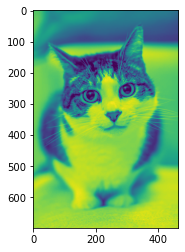

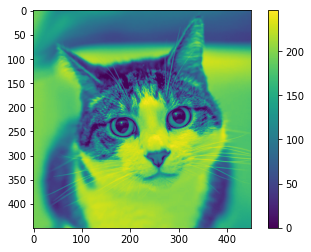

In [2]:
#画像を読み込んで単色化および450x450のサイズに変更する
_cat_ = np.array(Image.open('color/cat.jpg').convert('L'))
plt.imshow(_cat_)                           
plt.show()
cat = np.zeros((450,450))
for j in range(450):
    for i in range(450):
        cat[j,i] = _cat_[j+35,i] 
plt.imshow(cat)
plt.colorbar()

In [3]:
cat

array([[189., 189., 190., ...,  75.,  74.,  75.],
       [189., 189., 190., ...,  74.,  71.,  72.],
       [190., 190., 190., ...,  73.,  71.,  71.],
       ...,
       [192., 192., 192., ..., 141., 141., 140.],
       [192., 192., 192., ..., 141., 141., 140.],
       [192., 192., 192., ..., 140., 140., 140.]])

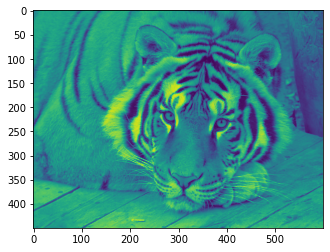

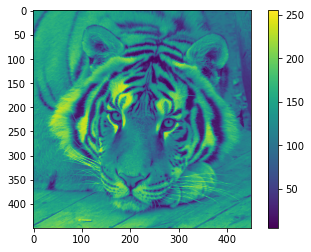

In [4]:
#画像を読み込んで単色化および450x450のサイズに変更する
_tiger_ = np.array(Image.open('color/tiger.jpg').convert('L').resize((np.int(900/1.5), np.int(675/1.5))))
plt.imshow(_tiger_)                           
plt.show()
tiger = np.zeros((450,450))
for j in range(450):
    for i in range(450):
        tiger[j,i] = _tiger_[j,i+110]
plt.imshow(tiger)
plt.colorbar()

In [11]:
#フーリエ変換した強度と位相を準備
#猫の画像
f_cat = np.fft.fft2(cat)
f_cat_int = np.abs(f_cat)#強度
f_cat_ph = f_cat/np.abs(f_cat)#位相
#虎の画像
f_tiger = np.fft.fft2(tiger)
f_tiger_int = np.abs(f_tiger)#強度
f_tiger_ph = f_tiger/np.abs(f_tiger)#位相

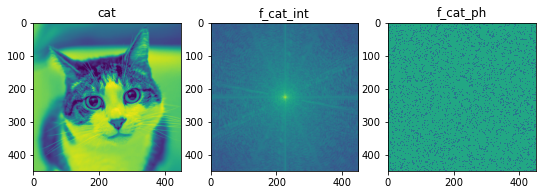

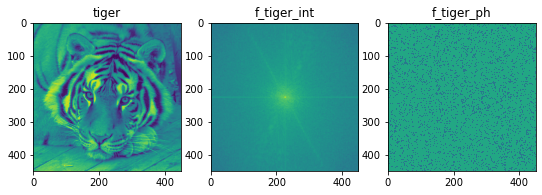

In [12]:
#強度と位相の画像をプロット
#猫の画像
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.title("cat")
plt.imshow(cat)
plt.subplot(1,3,2)
plt.title("f_cat_int")
plt.imshow(np.fft.fftshift(f_cat_int),norm=LogNorm())
plt.subplot(1,3,3)
plt.title("f_cat_ph")
plt.imshow(np.fft.fftshift(np.abs(f_cat_ph)))
#虎の画像
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.title("tiger")
plt.imshow(tiger)
plt.subplot(1,3,2)
plt.title("f_tiger_int")
plt.imshow(np.fft.fftshift(f_tiger_int),norm=LogNorm())
plt.subplot(1,3,3)
plt.title("f_tiger_ph")
plt.imshow(np.fft.fftshift(np.abs(f_tiger_ph)))

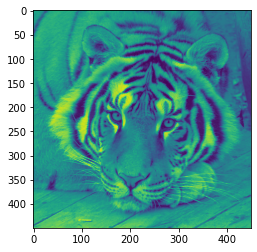

In [13]:
#逆フーリエ変換して実空間像を再構成する
#"強度x位相"のデータを変数fとして準備
f = f_tiger_int*f_tiger_ph
#変数fを逆フーリエ変換して実空間像に戻す
plt.imshow(np.real(np.fft.ifft2(f)))

In [14]:
#位相回復アルゴリズム

In [15]:
#関数を読み込む
#マスク作成
def make_mask(N):
    mask = np.zeros((N,N))
    for x in range(N):
        for y in range(N):
            if ((x-N/2)**2+(y-N/2)**2 < (N/5)**2 or (x-N/2+N/5)**2+(y-N/2)**2 < (N/11)**2 or (x-N/2)**2+(y-N/2-N/5)**2 < (N/10)**2) :
                mask[x,y] = 1 
    return mask
#位相回復アルゴリズム
def PRA(N, img_obs, img_org, _f_obs_, _mask_, _fmask_, _itr_):
    f_err_mask = np.array([])
    f_err_all = np.array([])
    r_err_mask = np.array([])
    r_err_all = np.array([])

    img = img_org*_mask_ + np.zeros((N,N))

    num = 0
    while num < _itr_:

        #FFT
        f_img = np.fft.fft2(img)
        _img_ = img + np.zeros((N,N))

        f_dif_mask = np.abs(_f_obs_-np.abs(f_img))*_fmask_
        f_dif_all = np.abs(_f_obs_-np.abs(f_img))
        r_dif_mask = np.abs(img_obs-img)*_mask_
        r_dif_all = np.abs(img_obs-img)

        f_err_mask = np.append(f_err_mask, 1/2*(np.linalg.norm(f_dif_mask))**2/N**4)
        f_err_all = np.append(f_err_all, 1/2*(np.linalg.norm(f_dif_all))**2/N**4)
        r_err_mask = np.append(r_err_mask, 1/2*(np.linalg.norm(r_dif_mask))**2/N**2)
        r_err_all = np.append(r_err_all, 1/2*(np.linalg.norm(r_dif_all))**2/N**2)


        #Q-constraint
        f_img = f_img/np.abs(f_img)*_f_obs_*_fmask_ + f_img*(1-_fmask_)

        #IFFT&R-constraint
        img = np.real(np.fft.ifft2(f_img))*_mask_        
        
        num = num + 1
    return img, r_err_mask, r_err_all, f_err_mask, f_err_all

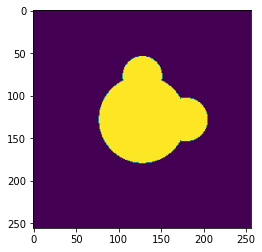

In [16]:
plt.imshow(make_mask(256))

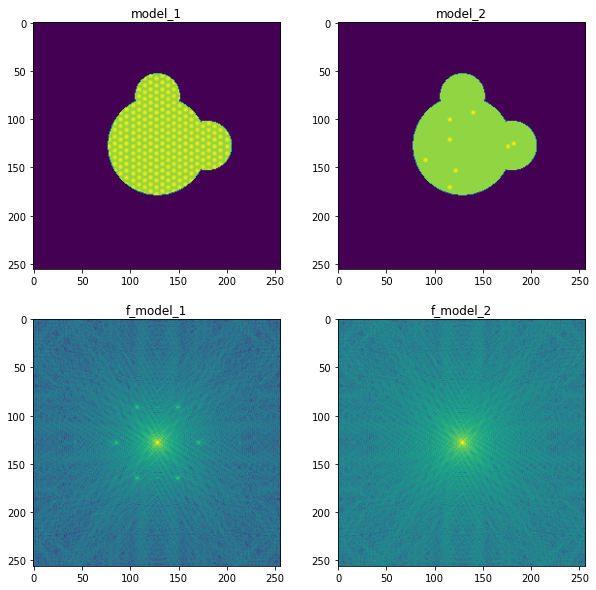

In [21]:
#モデル画像を読み込み
model_1 = np.loadtxt("color/model_1.txt")#三角格子
model_2 = np.loadtxt("color/model_2.txt")#孤立系
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("model_1")
plt.imshow(model_1)
plt.subplot(2,2,2)
plt.title("model_2")
plt.imshow(model_2)
plt.subplot(2,2,3)
plt.title("f_model_1")
plt.imshow(np.fft.fftshift(np.abs(np.fft.fft2(model_1)))**2,norm=LogNorm())
plt.subplot(2,2,4)
plt.title("f_model_2")
plt.imshow(np.fft.fftshift(np.abs(np.fft.fft2(model_2)))**2,norm=LogNorm())

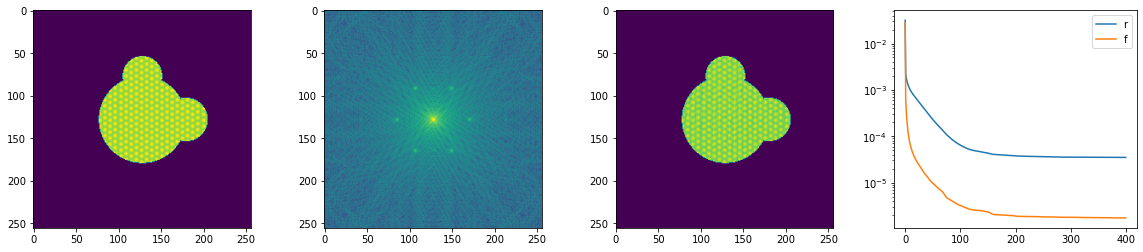

In [18]:
#位相回復アルゴリズムの実行
N = 256 #1辺のピクセル数
img_obs = np.loadtxt("color/model_1.txt")
img_org = (np.random.rand(N**2).reshape(N,N))
_f_obs_ = np.abs(np.fft.fft2(img_obs))
_mask_ = make_mask(N)
_fmask_ = np.ones((N,N))
_itr_ = 400
rslt = PRA(N, img_obs, img_org, _f_obs_, _mask_, _fmask_, _itr_)
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.imshow(img_obs)
plt.subplot(1,4,2)
plt.imshow(np.fft.fftshift(_f_obs_)**2,norm=LogNorm())
plt.subplot(1,4,3)
plt.imshow(rslt[0])
#plt.show()
plt.subplot(1,4,4)
plt.plot(rslt[1],label="r")
plt.plot(rslt[3],label="f")
plt.legend()
plt.yscale("log")

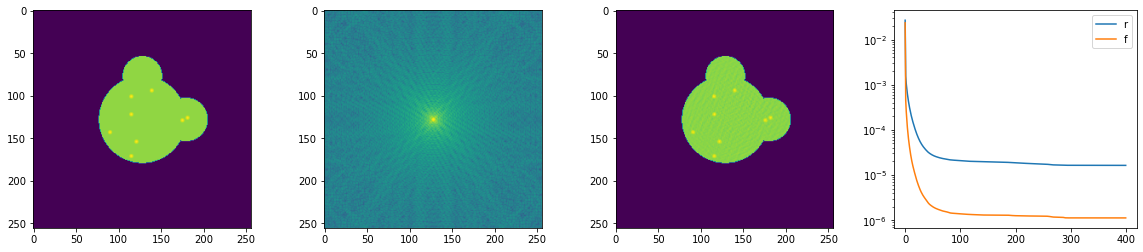

In [22]:
#位相回復アルゴリズムの実行
N = 256 #1辺のピクセル数
img_obs = np.loadtxt("color/model_2.txt")
img_org = (np.random.rand(N**2).reshape(N,N))
_f_obs_ = np.abs(np.fft.fft2(img_obs))
_mask_ = make_mask(N)
_fmask_ = np.ones((N,N))
_itr_ = 400
rslt = PRA(N, img_obs, img_org, _f_obs_, _mask_, _fmask_, _itr_)
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.imshow(img_obs)
plt.subplot(1,4,2)
plt.imshow(np.fft.fftshift(_f_obs_)**2,norm=LogNorm())
plt.subplot(1,4,3)
plt.imshow(rslt[0])
#plt.show()
plt.subplot(1,4,4)
plt.plot(rslt[1],label="r")
plt.plot(rslt[3],label="f")
plt.legend()
plt.yscale("log")